In [2]:
import numpy as np
import scipy.linalg as splin
from scipy.integrate import LSODA, solve_ivp
import matplotlib.pyplot as plt

from consts import *
from lyapunov import *
from pac import *
from potential import *
from lyap_obj import *

In [3]:
# Take a pair of isoenergetic orbits and propagate them for a period T.
# Then, take a point in the interval and compute the eigenvectors and eigenvalues
# of the STM on that point.

# Once this is done, we have Es, Eu, Ec1, Ec2
#### STABLE MANIFOLD
# Inizialize an orbit in x = p +- de*Es/|Es| and propagate backwards 

#### UNSTABLE MANIFOLD
# Inizialize an orbit in x = p +- de*Eu/|Eu| and propagate forward 


In [4]:
def compute_manifold(orbit: LyapOrbit, n_curves = 10):

    # Computes the stable and unstable manifolds of a given orbit
    
    # Perturbation parameter
    de = 40/384400

    # Compute the periodic orbit
    X, PHI = orbit.propagate()
    PHI = PHI.reshape(4,4)
    # Compute the length of the orbit
    length = len(X[0,:])
    
    T = orbit.T
    mu = orbit.mu
    sol_s = []
    sol_u = []

    for i in range(n_curves):
        p = X[:,i*length//n_curves]
        PHI_p = PHI[:,:,i*length//n_curves]

        assert spli.det(PHI_p) < 1e-10

         # Compute the eigenvectors and eigenvalues of the STM
        eigvals, eigvecs = splin.eig(PHI_p)

        # Compute the stable and unstable eigenvectors
        # E is stable if Re(eigval) < 1 and unstable if Re(eigval) > 1
        Es_idx = [i for i in range(len(eigvals)) if np.abs(eigvals[i]) < 1 and eigvals[i].imag == 0]
        Eu_idx = [i for i in range(len(eigvals)) if np.abs(eigvals[i]) > 1 and eigvals[i].imag == 0]

        # Take eigenvalues and eigenvectors
        Es, EVs = eigvals[Es_idx], eigvecs[:, Es_idx]
        Eu, EVu = eigvals[Eu_idx], eigvecs[:, Eu_idx]

        ### Compute deviation vectors
        # Stable
        X_s = p + de*EVs[:,0]/np.linalg.norm(EVs[:2,0])
        # Unstable
        X_u = p = de*EVu[:,0]/np.linalg.norm(EVu[:2,0])


        

        ### Propagate the deviation vectors
        # Build the initial conditions
        PHI0 = np.eye((4,4))
        X0s = np.concatenate((X_s, PHI0.flatten()))
        X0u = np.concatenate((X_u, PHI0.flatten()))
        
        
        
        # Stable (backwards)
        sol_s = solve_ivp(fdyn, [0, -T], X0s,t_eval= np.linspace(0, -T, 1000),
                           method='LSODA', args=(T, mu), rtol=1e-12, atol=3e-12)
        # Unstable (forward)
        sol_u = solve_ivp(fdyn, [0, T],X0u, t_eval= np.linspace(0,T, 1000),
                          method='LSODA', args=(T, mu), rtol=3e-12, atol=1e-12)

        # Extract the solution
        Xs = sol_s.y[:4,:]
        Xu = sol_u.y[:4,:]

        sol_s.append(Xs)
        sol_u.append(Xu)
    # End of loop
    # Plot the manifolds
    fig, ax = plt.subplots()
    for i in range(n_curves):
        ax.plot(sol_s[i][0,:], sol_s[i][1,:], 'b')
        ax.plot(sol_u[i][0,:], sol_u[i][1,:], 'r')
    
    return sol_s, sol_u









In [5]:
# Load orbits from file
L1_0 = load_orbit("out/L1_0.npz")
L1_1 = load_orbit("out/L1_1.npz")

L2_0 = load_orbit("out/L2_0.npz")
L2_1 = load_orbit("out/L2_1.npz")

L1_orbits = [L1_0, L1_1]
L2_orbits = [L2_0, L2_1]

In [6]:
print(f"mu = {L1_0.mu}")

mu = 0.012144731052598496


In [7]:
# Orbits are contained in 
# orbsL1
# isoC_L2
# For good measure, set C of the orbits with a e-4 accuracy
for i in range(len(L1_orbits)):
    # Truncate to 4 decimal places without rounding
    C = np.round(L1_orbits[i].C, 4)
    L1_orbits[i].C = C
    L2_orbits[i].C = C

In [8]:
de = 40/384400

# Compute states of the orbits
pair = 0 # pair of orbits to use

# Compute the states of the orbits
# L1
X1, PHI1 = L1_orbits[pair].propagate()
# L2
X2, PHI2 = L2_orbits[pair].propagate()

T = L1_orbits[pair].Yd[2]

# Take 
p = X1[:4, -1]
PHI1_pT = PHI1[:,:, -1]

# Compute the eigenvectors and eigenvalues of the STM at p
eigvals, eigvecs = splin.eig(PHI1_pT)
print(f"Eigenvalues: {eigvals}")
print(f"abs(eigvals): {np.abs(eigvals)}")

# Compute the stable and unstable eigenvectors
Es_idx = [i for i in range(len(eigvals)) if np.abs(eigvals[i]) < 1 and eigvals[i].imag == 0]
Eu_idx = [i for i in range(len(eigvals)) if np.abs(eigvals[i]) > 1 and eigvals[i].imag == 0]

# Take eigenvalues and eigenvectors(only position components)
Es, EVs = eigvals[Es_idx], eigvecs[:, Es_idx]
Eu, EVu = eigvals[Eu_idx], eigvecs[:, Eu_idx]

print(f"Es: {Es}")
print(f"EVs: {EVs}")
print(f"Eu: {Eu}")
print(f"EVu: {EVu}")

Eigenvalues: [ 2.18061410e+09+0.j         -3.04866693e-07+0.j
 -1.91114305e-01+0.98156776j -1.91114305e-01-0.98156776j]
abs(eigvals): [2.18061410e+09 3.04866693e-07 9.99999973e-01 9.99999973e-01]
Es: [-3.04866693e-07+0.j]
EVs: [[ 0.33724944+0.j]
 [ 0.09525662+0.j]
 [-0.8716538 +0.j]
 [-0.34264945+0.j]]
Eu: [2.1806141e+09+0.j]
EVu: [[-0.38333832+0.j]
 [ 0.08409657+0.j]
 [-0.8920234 +0.j]
 [ 0.22421811+0.j]]


In [9]:
# Now that we have the stable and unstable eigenvecs, we can compute the deviation
# from the initial point p
de = 40/384400
xs_p = p + de*EVs[:, 0]/np.linalg.norm(EVs[:2, 0])
xs_m = p - de*EVs[:, 0]/np.linalg.norm(EVs[:2, 0])
# Strip the imaginary part
xs_p = np.real(xs_p)
xs_m = np.real(xs_m)

# Build state vector
# xs_p = np.concatenate((xs_p, np.zeros(2)))
# xs_m = np.concatenate((xs_m, np.zeros(2)))

# Add the STM to the state vector
PHI0 = np.eye(4)

Xs_p = np.concatenate((xs_p, PHI0.flatten()))
Xs_m = np.concatenate((xs_m, PHI0.flatten()))
print(f"Xs_p: {Xs_p}")
print(f"Xs_m: {Xs_m}")

# Propagate the state vectors
sols_p = solve_ivp(fdyn, [0, -2*T], Xs_p, args = (T,muEM), method='LSODA', rtol=3e-14, atol=1e-14)
sols_m = solve_ivp(fdyn, [0, -2*T], Xs_m, args = (T,muEM), method='LSODA', rtol=3e-14, atol=1e-14)

# Lenght of the solution
n = len(sols_p.t)
print(f"n: {n}")
print(T)


Xs_p: [ 0.8284139  -0.07318528 -0.06645332  0.15135351  1.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          1.        ]
Xs_m: [ 0.82821362 -0.07324184 -0.06593568  0.15155699  1.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          1.        ]
n: 25492
[2.87071409]


In [10]:
Cj = L1_1.C
mu = L1_1.mu

# Compute the zero velocity curve
x = np.linspace(-2, 2, 1000)
y = np.linspace(-2, 2, 1000)

X, Y = np.meshgrid(x, y)

U_ = np.zeros_like(X)
for i in range(len(x)):
    for j in range(len(y)):
        U_[i,j] = U(np.array([x[i], y[j]]), mu) 
# Black contour

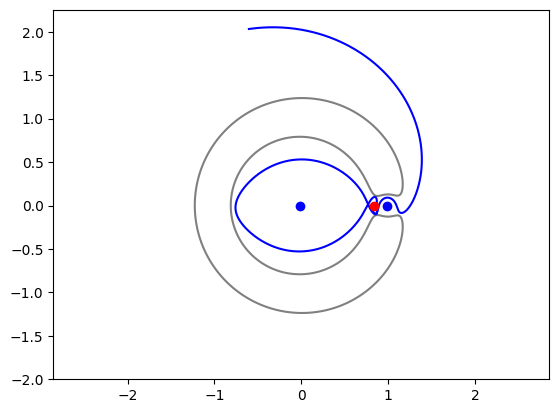

In [14]:

#$plt.contourf(Y, X, U_, levels = [Cj/2], colors = 'k')
# Plot the zero velocity curve filled with gray
plt.contour(Y, X, U_, levels = [Cj/2], colors = 'gray')

trak_p = sols_p.y[:2, :]
trak_m = sols_m.y[:2, :]
#plt.plot(trak_p[0, :], trak_p[1, :], 'b')
plt.plot(trak_m[0, :], trak_m[1, :], 'b')

plt.plot(XL1[0], XL1[1], 'ro')
plt.plot(1-muEM, 0, 'bo') 
plt.plot(-muEM, 0, 'bo')
plt.axis('equal')
plt.show()

In [10]:
xu_p = p + de*EVu[:, 0]/np.linalg.norm(EVu[:2, 0])
xu_m = p - de*EVu[:, 0]/np.linalg.norm(EVu[:2, 0])

# Strip the imaginary part
xu_p = np.real(xu_p)
xu_m = np.real(xu_m)

# xu_p = np.concatenate((xu_p, np.zeros(2)))
# xu_m = np.concatenate((xu_m, np.zeros(2)))



# Add the STM to the state vector
PHI0 = np.eye(4)

Xu_p = np.concatenate((xu_p, PHI0.flatten()))
Xu_m = np.concatenate((xu_m, PHI0.flatten()))

# Propagate the state vectors
solu_p = solve_ivp(fdyn, [0, 2*T], Xu_p, args = (T,muEM), method='LSODA', rtol=3e-12, atol=1e-12)
solu_m = solve_ivp(fdyn, [0, 2*T], Xu_m, args = (T,muEM), method='LSODA', rtol=3e-12, atol=1e-12)

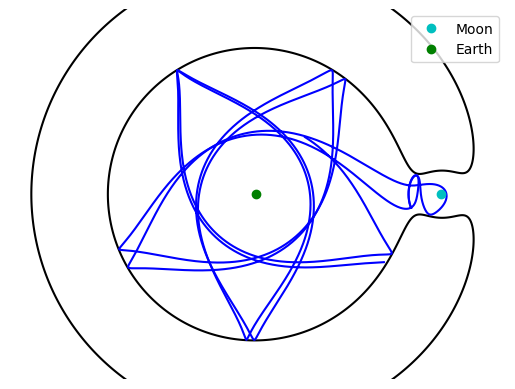

In [52]:

#$plt.contourf(Y, X, U_, levels = [Cj/2], colors = 'k')
# Plot the zero velocity curve filled with gray
plt.contour(Y, X, U_, levels = [Cj/2], colors = 'k')



trau_p = solu_p.y[:2, :]
trau_m = solu_m.y[:2, :]
plt.plot(trau_p[0, :], trau_p[1, :], 'b')
plt.plot(trau_m[0, :], trau_m[1, :], 'b')

#plt.plot(XL1[0], XL1[1], 'ro')
plt.plot(1-muEM, 0, 'co', label = "Moon")
plt.plot(-muEM, 0, 'go', label = "Earth")
plt.axis('equal')

plt.axis('equal')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.legend()
plt.axis("off")
plt.show()